# normalization: compute relative logs to itself
# categorization: group experiments by the matching training domain
# pairing: compute additional benefit of a new objective compared to the corresponding (paired) MLE objective
# --> for each Update step, compute additive "improvements" to corresponding MLE, then plot as a sum of "MLE + improvement"
# variance: for each Update step, plot each "improvement" as 1. either confidence interval (e.g. Violin), or 2. min + avg + max lineplot

In [249]:
experiments_ids = ["dec_sbert+seq_w25_lr1e-6_wiki", "seq_wiki", "zero_sbert_w1k+seq_lr2e-6_wiki", "dec_tbert+seq_w25_lr2e-7_wiki"]

In [250]:
import comet_ml
import pandas as pd

api = comet_ml.api.API(api_key="1KCZPXV4mEZdXMcF824fMtEo4")


def experiment_log(experiment_id: str, domain: str, metric: str = "BLEU",
                   project_name: str = "soft-obj2", smoothing_window: int = None) -> pd.Series:
    experiment = api.get("stefanik12",project_name, experiment_id)
    metrics = experiment.get_metrics(metric="eval_%s-Sequence2Sequence_%s-gen" % (domain, metric))
    log = pd.Series([float(entry['metricValue']) for entry in metrics], index=[int(entry['step']) for entry in metrics])

    norm = log.iloc[0]
    log /= norm
    # smoothing?
    if smoothing_window is not None:
        log = log.rolling(window=smoothing_window, center=True).mean()
        log[pd.isna(log)] = 1
        log = log.iloc[smoothing_window - 2  // 2:-(smoothing_window // 2 + 1)]

    return log

In [251]:
objectives_identifiers = ["random_sbert", "dec_sbert", "sbert", "dec_tbert", "seq"]

train_domains = ["Wiki"]
eval_domains = ["Bible", "Opensub", "Wiki"]

In [252]:
reference_logs = {}
reported_improvements = {}


for train_domain in train_domains:
    train_domain_experiments = [e for e in experiments_ids if train_domain.lower() in e]
    new_objective_experiments = [e for e in train_domain_experiments if "+seq_" in e]

    reference_experiment_id = next(e for e in train_domain_experiments if e not in new_objective_experiments)
    reference_logs[train_domain] = {eval_domain: experiment_log(reference_experiment_id, eval_domain) for eval_domain in eval_domains}

    reported_improvements[train_domain] = {}
    for eval_objective in new_objective_experiments:
        reported_logs = {eval_domain: experiment_log(eval_objective, eval_domain) for eval_domain in eval_domains}
        reported_improvements[train_domain][eval_objective] = {eval_domain: eval_log - reference_logs[train_domain][eval_domain]
                                                               for eval_domain, eval_log in reported_logs.items()}

<AxesSubplot:>

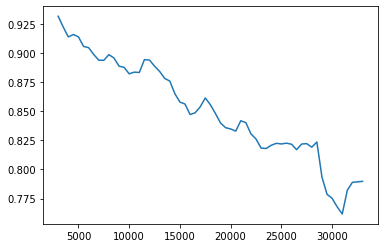

In [222]:
reference_logs["Wiki"]["Opensub"].plot()

<AxesSubplot:>

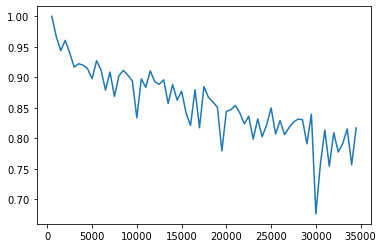

In [200]:
# non-smoothed version
reference_logs["Wiki"]["Opensub"].plot()

<AxesSubplot:>

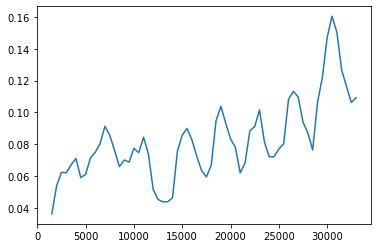

In [217]:
reported_improvements["Wiki"]['zero_sbert_w1k+seq_lr2e-6_wiki']["Opensub"].plot()

In [234]:
id_ref = pd.concat((pd.concat([eval_logs for eval_domain, eval_logs in train_domain_refs.items() if eval_domain in train_domains], axis=1)
                    for train_domain, train_domain_refs in reference_logs.items()), axis=1).mean(axis=1)

ood_ref = pd.concat((pd.concat([eval_logs for eval_domain, eval_logs in train_domain_refs.items() if eval_domain not in train_domains], axis=1)
                          for train_domain, train_domain_refs in reference_logs.items()), axis=1).mean(axis=1)

<AxesSubplot:>

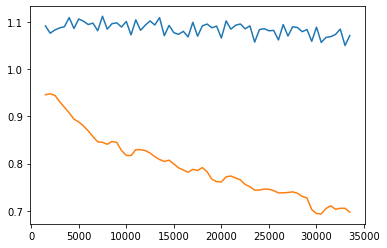

In [229]:
id_ref.plot()
ood_ref.plot()

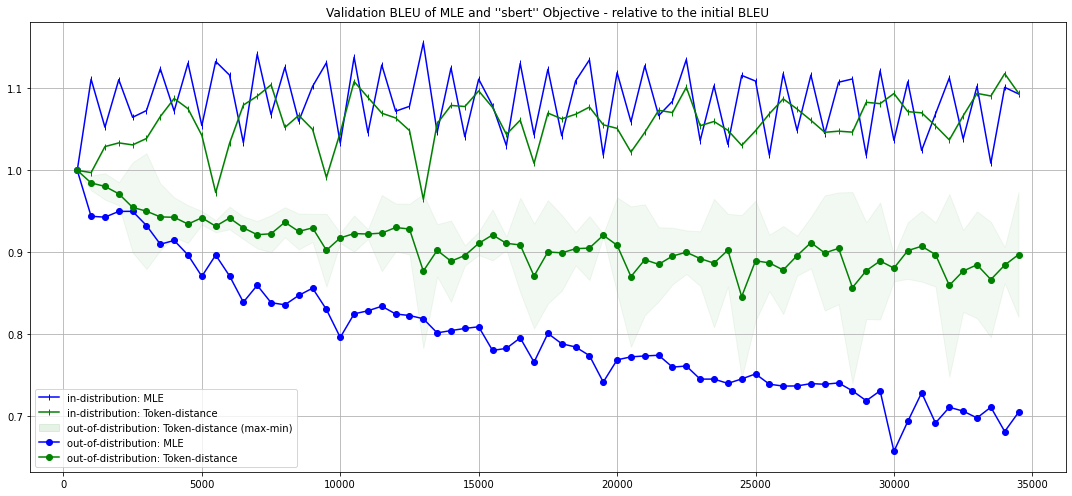

In [258]:
import matplotlib.pyplot as plt

plotted_objective = "zero_sbert_w1k+seq_lr2e-6_wiki"
# plotted_objective = "dec_sbert+seq_w25_lr1e-6_wiki"
# plotted_objective = "dec_tbert+seq_w25_lr2e-7_wiki"

objective_id = next(identifier for identifier in objectives_identifiers if identifier in plotted_objective)

# id
id_change = pd.concat((pd.concat([eval_logs for eval_domain, eval_logs in train_domain_refs[plotted_objective].items()
                                  if eval_domain in train_domains], axis=1)
                    for train_domain, train_domain_refs in reported_improvements.items()), axis=1)
id_change = id_change.dropna()

id_improvement_upper = (id_ref + id_change.max(axis=1)).dropna()
id_improvement_mean =  (id_ref + id_change.mean(axis=1)).dropna()
id_improvement_lower = (id_ref + id_change.min(axis=1)).dropna()

fig, ax = plt.subplots()
id_ref.plot(ax=ax, color="b", marker="|")
id_improvement_mean.dropna().plot(ax=ax, grid=True, figsize=(15, 7), color="g", marker="|")
ax.fill_between(id_improvement_mean.dropna().index, id_improvement_lower.dropna(), id_improvement_upper.dropna(), color='g', alpha=.1)

# ood
ood_change = pd.concat((pd.concat([eval_logs for eval_domain, eval_logs in train_domain_refs[plotted_objective].items()
                                  if eval_domain not in train_domains], axis=1)
                    for train_domain, train_domain_refs in reported_improvements.items()), axis=1)
ood_change = ood_change.dropna()

ood_improvement_upper = (ood_ref + ood_change.max(axis=1)).dropna()
ood_improvement_mean =  (ood_ref + ood_change.mean(axis=1)).dropna()
ood_improvement_lower = (ood_ref + ood_change.min(axis=1)).dropna()

# fig, ax = plt.subplots()
ood_ref.plot(ax=ax, color="b", marker="o")
ood_improvement_mean.plot(ax=ax, grid=True, figsize=(15, 7), color="g", marker="o")
ax.fill_between(ood_improvement_mean.index, ood_improvement_lower.values, ood_improvement_upper.values, color='g', alpha=.05)

ax.legend(["in-distribution: MLE", "in-distribution: Token-distance",
           "out-of-distribution: Token-distance (max-min)", "out-of-distribution: MLE", "out-of-distribution: Token-distance", ])
_ = plt.title("Validation BLEU of MLE and ''%s'' Objective - relative to the initial BLEU" % objective_id)
plt.tight_layout()
plt.savefig("%s-%s_train_domains-%s_eval_domains" % (plotted_objective, len(train_domains), len(eval_domains)), format="png", dpi=300)

In [248]:
id_change

,0
1000,-0.101782
2000,-0.048625
3000,-0.005637
4000,0.037707
5000,0.063761
6000,-0.030591
7000,-0.026138
8000,-0.003979
9000,0.005605
10000,0.054438
